In [1]:
# Run this cell to import pyspark and to define start_spark() and stop_spark()

import findspark

findspark.init()

import getpass
import pandas
import pyspark
import random
import re

from IPython.display import display, HTML
from pyspark import SparkContext
from pyspark.sql import SparkSession


# Functions used below

def username():
    """Get username with any domain information removed.
    """

    return re.sub('@.*', '', getpass.getuser())


def dict_to_html(d):
    """Convert a Python dictionary into a two column table for display.
    """

    html = []

    html.append(f'<table width="100%" style="width:100%; font-family: monospace;">')
    for k, v in d.items():
        html.append(f'<tr><td style="text-align:left;">{k}</td><td>{v}</td></tr>')
    html.append(f'</table>')

    return ''.join(html)


def show_as_html(df, n=20):
    """Leverage existing pandas jupyter integration to show a spark dataframe as html.
    
    Args:
        n (int): number of rows to show (default: 20)
    """

    display(df.limit(n).toPandas())

    
def display_spark():
    """Display the status of the active Spark session if one is currently running.
    """
    
    if 'spark' in globals() and 'sc' in globals():

        name = sc.getConf().get("spark.app.name")
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:green">active</span></b>, look for <code>{name}</code> under the running applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'<li><a href="{sc.uiWebUrl}" target="_blank">Spark Application UI</a></li>',
            f'</ul>',
            f'<p><b>Config</b></p>',
            dict_to_html(dict(sc.getConf().getAll())),
            f'<p><b>Notes</b></p>',
            f'<ul>',
            f'<li>The spark session <code>spark</code> and spark context <code>sc</code> global variables have been defined by <code>start_spark()</code>.</li>',
            f'<li>Please run <code>stop_spark()</code> before closing the notebook or restarting the kernel or kill <code>{name}</code> by hand using the link in the Spark UI.</li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))
        
    else:
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:red">stopped</span></b>, confirm that <code>{username() + " (jupyter)"}</code> is under the completed applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))


# Functions to start and stop spark

def start_spark(executor_instances=2, executor_cores=1, worker_memory=1, master_memory=1):
    """Start a new Spark session and define globals for SparkSession (spark) and SparkContext (sc).
    
    Args:
        executor_instances (int): number of executors (default: 2)
        executor_cores (int): number of cores per executor (default: 1)
        worker_memory (float): worker memory (default: 1)
        master_memory (float): master memory (default: 1)
    """

    global spark
    global sc

    user = username()
    
    cores = executor_instances * executor_cores
    partitions = cores * 4
    port = 4000 + random.randint(1, 999)

    spark = (
        SparkSession.builder
        .master("spark://masternode2:7077")
        .config("spark.driver.extraJavaOptions", f"-Dderby.system.home=/tmp/{user}/spark/")
        .config("spark.dynamicAllocation.enabled", "false")
        .config("spark.executor.instances", str(executor_instances))
        .config("spark.executor.cores", str(executor_cores))
        .config("spark.cores.max", str(cores))
        .config("spark.executor.memory", f"{worker_memory}g")
        .config("spark.driver.memory", f"{master_memory}g")
        .config("spark.driver.maxResultSize", "0")
        .config("spark.sql.shuffle.partitions", str(partitions))
        .config("spark.ui.port", str(port))
        .appName(user + " (jupyter)")
        .getOrCreate()
    )
    sc = SparkContext.getOrCreate()
    
    display_spark()

    
def stop_spark():
    """Stop the active Spark session and delete globals for SparkSession (spark) and SparkContext (sc).
    """

    global spark
    global sc

    if 'spark' in globals() and 'sc' in globals():

        spark.stop()

        del spark
        del sc

    display_spark()


# Make css changes to improve spark output readability

html = [
    '<style>',
    'pre { white-space: pre !important; }',
    'table.dataframe td { white-space: nowrap !important; }',
    'table.dataframe thead th:first-child, table.dataframe tbody th { display: none; }',
    '</style>',
]
display(HTML(''.join(html)))

In [2]:
USER_DIRECTORY = "hdfs:///user/nki38/outputs/ghcnd/"

In [3]:
#You may increase your resources
#up to 4 executors, 2 cores per executor, 4 GB of executor memory, and 4 GB of master memory.

start_spark(executor_instances=4, executor_cores=2, worker_memory=4, master_memory=4)

spark.dynamicAllocation.enabled,false
spark.executor.instances,4
spark.driver.memory,4g
spark.executor.memory,4g
spark.sql.warehouse.dir,file:/users/home/nki38/spark-warehouse/
spark.master,spark://masternode2:7077
spark.ui.port,4740
spark.app.startTime,1714288207788
spark.executor.id,driver
spark.executor.cores,2
spark.driver.host,mathmadslinux2p.canterbury.ac.nz


In [4]:

import pyspark.sql.functions as F
from pyspark.sql.types import *

schema = StructType([
    StructField("ID", StringType(), False),
    StructField("DATE", IntegerType(), True),
    StructField("ELEMENT", StringType(), True),
    StructField("VALUE", DoubleType(), True),
    StructField("MEASUREMENT FLAG", StringType(), True),
    StructField("QUALITY FLAG", StringType(), True),
    StructField("SOURCE FLAG", StringType(), True),
    StructField("OBSERVATION TIME", StringType(), True) 
])

NZ_STATIONS_DF = spark.read.csv('/user/nki38/outputs/ghcnd/NZ_Stations_ANALYSIS.csv', schema=schema, header=True)
print(NZ_STATIONS_DF.count())
NZ_STATIONS_DF.printSchema()

485520
root
 |-- ID: string (nullable = true)
 |-- DATE: integer (nullable = true)
 |-- ELEMENT: string (nullable = true)
 |-- VALUE: double (nullable = true)
 |-- MEASUREMENT FLAG: string (nullable = true)
 |-- QUALITY FLAG: string (nullable = true)
 |-- SOURCE FLAG: string (nullable = true)
 |-- OBSERVATION TIME: string (nullable = true)



In [83]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
def plot_time_series_years_only(data1, data2, years1, years2, title=''):
    """
    Plots two sets of temperature data as time series on the same matplotlib graph.

    Parameters:
        data1 (list or numpy array): First set of temperature data points (TMAX).
        data2 (list or numpy array): Second set of temperature data points (TMIN).
        years1 (list or numpy array): Array of years corresponding to data1.
        years2 (list or numpy array): Array of years corresponding to data2.
        title (str): Title of the plot.

    Returns:
        None
    """
    plt.figure(figsize=(10, 3))
    # Plotting data1 (TMAX)
    plt.plot(years1, data1, label='TMAX')

    # Plotting data2 (TMIN)
    plt.plot(years2, data2, label='TMIN')

    # Adding labels, legend, and title
    plt.xlabel('Years')
    plt.ylabel('Temperature')
    plt.title(title)
    plt.legend()

    # Displaying the plot
    plt.show()

# Example usage:
# Assuming data1 (TMAX), data2 (TMIN), and years are defined elsewhere
# plot_time_series(data1, data2, years, title='Temperature Time Series Plot')

def plot_time_series(TMIN, TMAX, TIME_1, TIME_2, station="undefined", set_axis=True, years_only=False):
    """
    Plot two lines on the same graph for time series.

    Parameters:
        TMIN (list): Time series data for TMIN.
        TMAX (list): Time series data for TMAX.
        TIME_1 (list): Time values corresponding to TMIN and TMAX.
        TIME_2 (list): Time values corresponding to TMIN and TMAX.
    """
    plt.figure(figsize=(10, 3))  # Adjust the height (3 inches) to make the figure shorter
    
    # Plot TMIN and TMAX lines

    # Set date format on x-axis
    if years_only:
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    else:
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    
    # Inform the axis that it is plotting dates
    plt.plot(TIME_1, TMIN, label='TMIN', color='blue')
    plt.plot(TIME_2, TMAX, label='TMAX', color='red')
    
    
    # Add title and labels
    plt.title(f"TMIN & TMAX for station {station}")
    plt.xlabel('Time')
    plt.ylabel('Temperature')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Set the x-axis limits
    if set_axis:
        plt.xlim('1940-01-01', '2024-12-31')
    
    # Add legend
    plt.legend()
    
    # Show grid
    plt.grid(False)
    
    # Show the plot
    plt.show()

# Example usage:
# Assume TMIN, TMAX, TIME_1, and TIME_2 are lists containing the corresponding data
# plot_time_series(TMIN, TMAX, TIME_1, TIME_2, years_only=True)


In [6]:
from pyspark.sql import functions as F

print(NZ_STATIONS_DF.count())

#print(filtered_df.count())#
# Convert DATE column to date format\

# filtered_df = NZ_STATIONS_DF.withColumn('DATE', F.to_date(F.col('DATE').cast('string'), 'yyyyMMdd'))
# filtered_df.show()

485520


In [7]:
station_ids = NZ_STATIONS_DF.select('ID').distinct()
station_ids.show()
stations = station_ids.collect()
print(station_ids.count())

+-----------+
|         ID|
+-----------+
|NZ000936150|
|NZ000093012|
|NZ000093292|
|NZM00093678|
|NZ000093844|
|NZ000093417|
|NZ000933090|
|NZ000093994|
|NZM00093110|
|NZ000937470|
|NZ000939870|
|NZM00093781|
|NZ000939450|
|NZM00093929|
|NZM00093439|
+-----------+

15


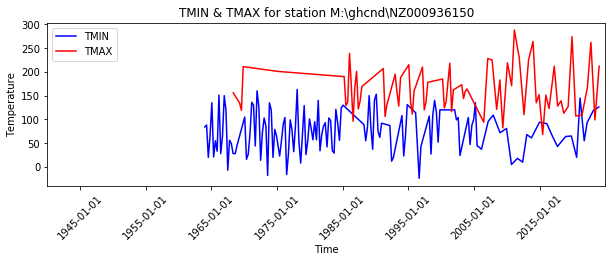

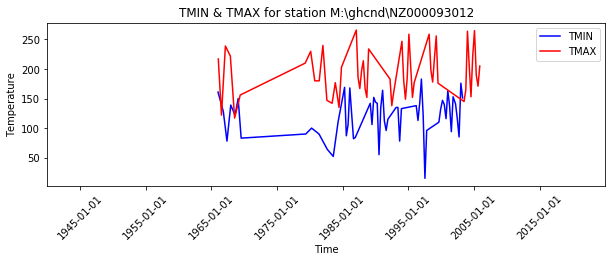

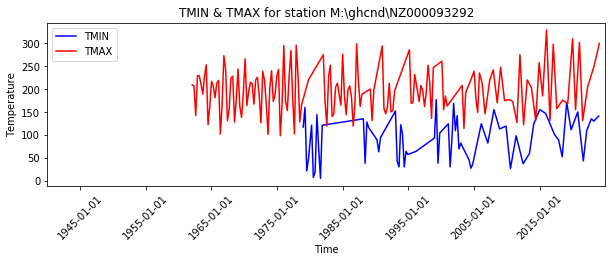

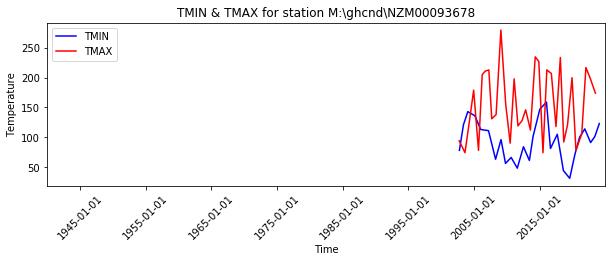

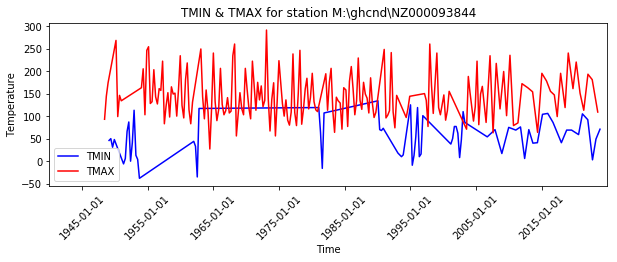

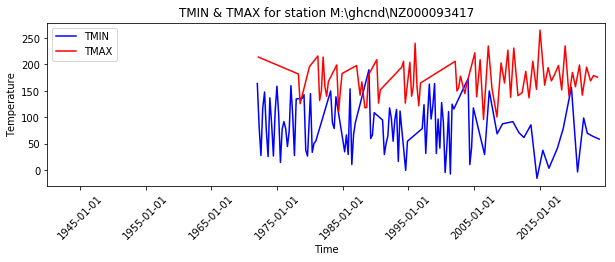

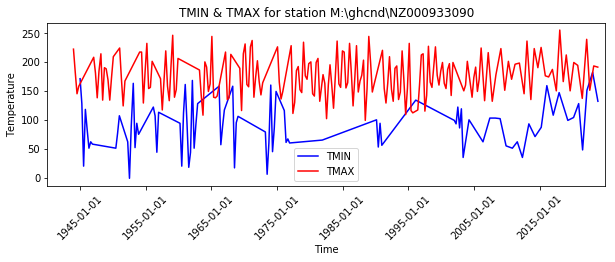

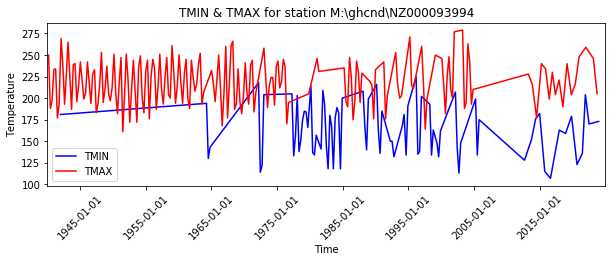

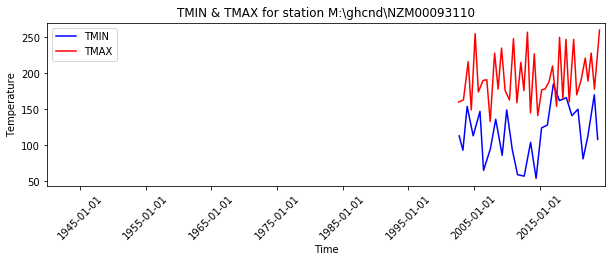

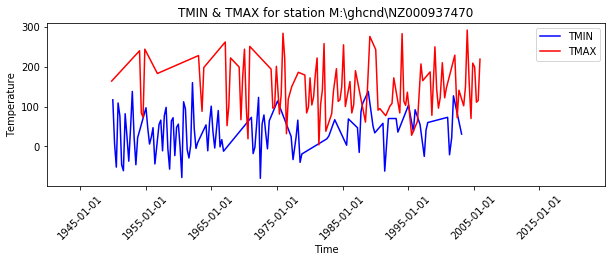

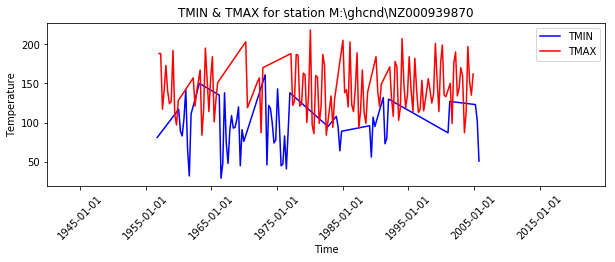

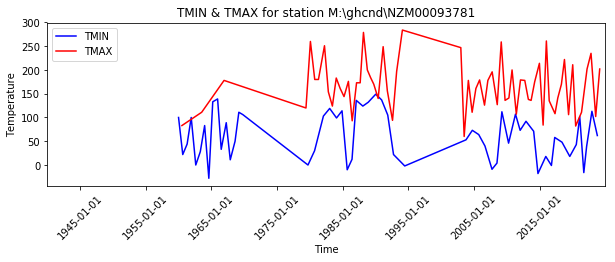

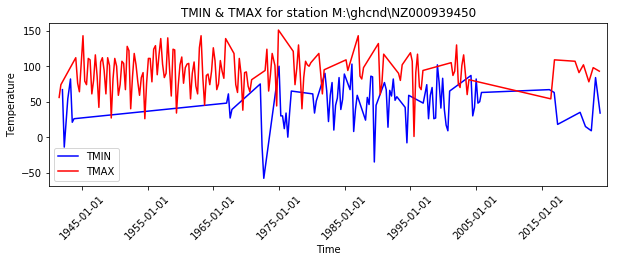

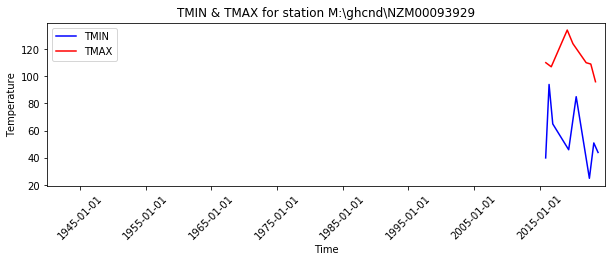

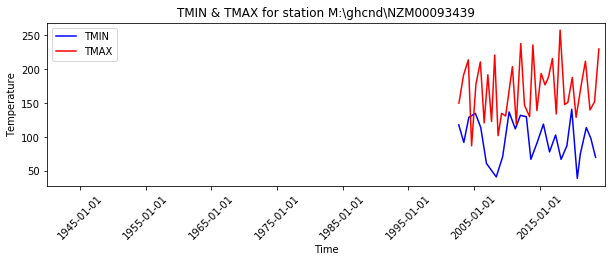

In [8]:
from datetime import datetime
from pyspark.sql import Window
spacer = 14

for station in stations:
    station = station['ID']
    current = NZ_STATIONS_DF.filter(F.col("ID") == station)

    current = current.withColumn("DATE", F.to_timestamp(F.col("DATE").cast("string"), "yyyyMMdd"))
    current = current.withColumn("DATE", F.date_format("DATE", "yyyy-MM-dd"))

    windowSpec = Window.partitionBy('ID', 'ELEMENT').orderBy('DATE').rowsBetween(-29, 0)  # Rolling window of 30 rows
    rolling_avg = F.avg('VALUE').over(windowSpec)
    averaged_df = current.withColumn('ROLLING_AVG', rolling_avg)
    
    current = averaged_df.filter((F.monotonically_increasing_id() % spacer) == 0)
    
    TMAXs = current.filter(F.col('ELEMENT') == 'TMAX').select('DATE','VALUE').orderBy('DATE')
    TMINs = current.filter(F.col('ELEMENT') == 'TMIN').select('DATE','VALUE').orderBy('DATE')

    data = TMAXs.collect()[::spacer]
    TMAX_dates = [datetime.strptime(row['DATE'], '%Y-%m-%d')for row in data]
    TMAX_values = [row['VALUE'] for row in data]

    
    data = TMINs.collect()[::spacer]
    TMIN_dates = [datetime.strptime(row['DATE'], '%Y-%m-%d')for row in data]
    TMIN_values = [row['VALUE'] for row in data]
    
    plot_time_series(TMIN_values,TMAX_values,TMIN_dates, TMAX_dates, station=station)


+----------+------------------+
|      DATE|         AVG_VALUE|
+----------+------------------+
|1941-01-18|             249.0|
|1941-03-01|             256.0|
|1941-04-30|             242.0|
|1942-05-31|             228.0|
|1942-06-04|             219.0|
|1942-06-16|             172.0|
|1942-09-18|             215.0|
|1943-08-12|             124.0|
|1943-08-24|             114.5|
|1944-10-03|             156.0|
|1944-10-30|135.66666666666666|
|1944-11-25|158.33333333333334|
|1944-11-26|167.33333333333334|
|1945-07-22|138.66666666666666|
|1945-09-13|139.33333333333334|
|1945-11-28|175.66666666666666|
|1946-01-11|             175.0|
|1946-02-28|185.66666666666666|
|1946-03-06|             173.0|
|1946-08-04|             133.0|
+----------+------------------+
only showing top 20 rows

+----------+------------------+
|      DATE|         AVG_VALUE|
+----------+------------------+
|1940-05-05|             167.0|
|1940-07-13|             118.0|
|1940-07-23|             147.0|
|1940-07-29|  

FileNotFoundError: [Errno 2] No such file or directory: 'M:/ghcnd/station_graph Entire country.png'

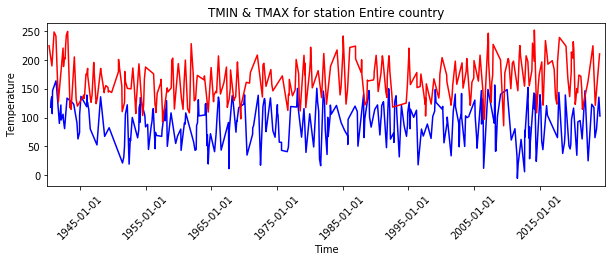

In [36]:
spacer = 1

filtered_df = NZ_STATIONS_DF.filter((NZ_STATIONS_DF['ELEMENT'] == 'TMIN') | (NZ_STATIONS_DF['ELEMENT'] == 'TMAX'))
filtered_df = filtered_df.withColumn('DATE', F.to_date(F.col('DATE').cast('string'), 'yyyyMMdd'))
avg_df = filtered_df.groupBy('DATE', 'ELEMENT').agg(F.avg('VALUE').alias('AVG_VALUE'))
avg_df = avg_df.filter((F.monotonically_increasing_id() % 100) == 0)
TMAX_df = avg_df.filter(F.col('ELEMENT') == "TMAX").select('DATE','AVG_VALUE').orderBy('DATE')
TMIN_df = avg_df.filter(F.col('ELEMENT') == "TMIN").select('DATE','AVG_VALUE').orderBy('DATE')



TMAX_df.show()
TMIN_df.show()

data = TMAX_df.collect()[::spacer]
TMAX_dates = [row['DATE'] for row in data]
TMAX_values = [row['AVG_VALUE'] for row in data]

    
data = TMIN_df.collect()[::spacer]
TMIN_dates = [row['DATE'] for row in data]
TMIN_values = [row['AVG_VALUE'] for row in data]



print(TMAX_df.count(), TMIN_df.count())
plot_time_series(TMIN_values,TMAX_values,TMIN_dates, TMAX_dates, station="Entire country")


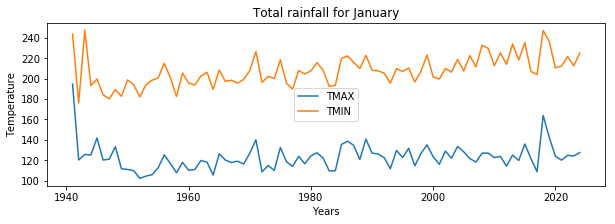

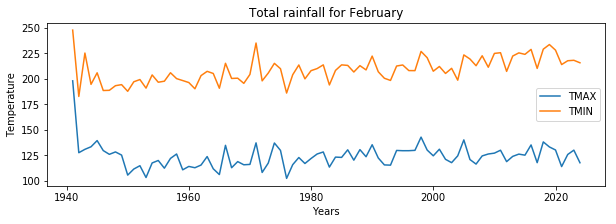

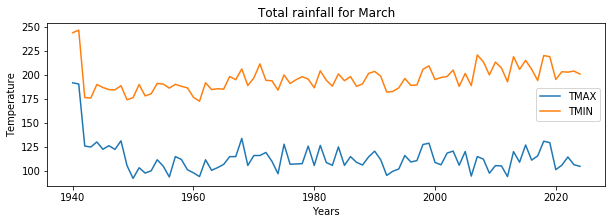

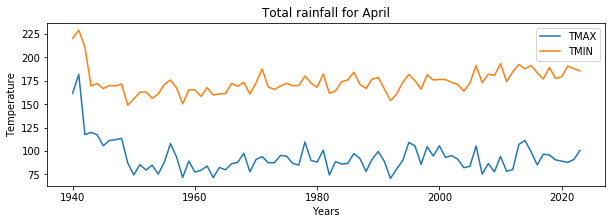

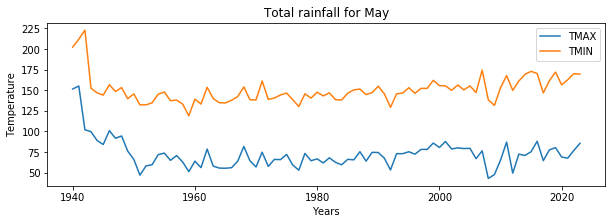

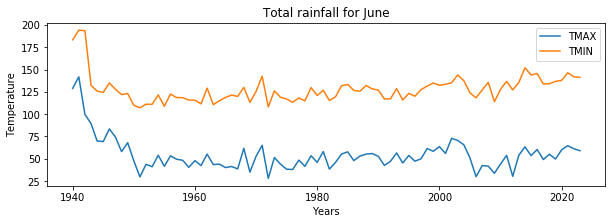

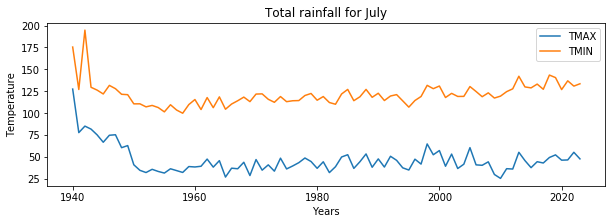

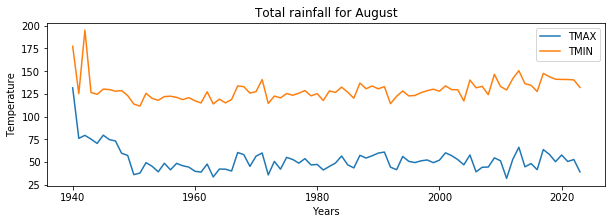

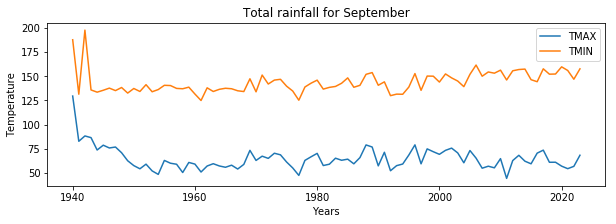

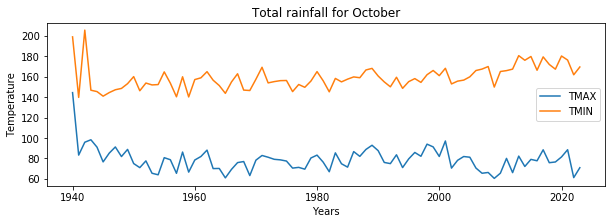

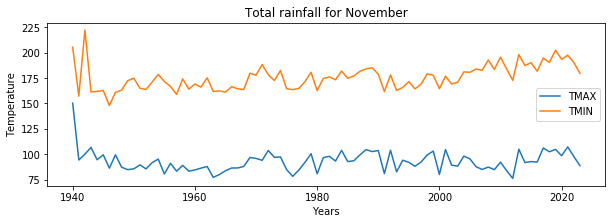

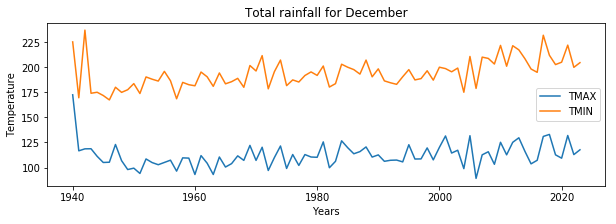

In [84]:
spacer = 1
filtered_df = NZ_STATIONS_DF.filter((NZ_STATIONS_DF['ELEMENT'] == 'TMIN') | (NZ_STATIONS_DF['ELEMENT'] == 'TMAX'))

# Convert DATE column to date format
filtered_df = filtered_df.withColumn('DATE', F.to_date(F.col('DATE').cast('string'), 'yyyyMMdd'))






filtered_df = filtered_df.withColumn('MONTH', F.month('DATE'))
filtered_df = filtered_df.withColumn('YEAR', F.year('DATE'))








avg_df = filtered_df.groupBy('YEAR', 'MONTH', 'ELEMENT').agg(F.avg('VALUE').alias('AVG_VALUE'))
pivoted_df = avg_df.groupBy('YEAR', 'MONTH').pivot('ELEMENT').agg(F.avg('AVG_VALUE'))


pivoted_df = pivoted_df.withColumn('MONTH_STR', F.expr("LPAD(MONTH, 2, '0')"))
pivoted_df = pivoted_df.withColumn('DATE', F.concat_ws('-', F.col('YEAR'), F.col('MONTH_STR'), F.lit('01')))
pivoted_df = pivoted_df.withColumn('DATE', F.to_date('DATE', 'yyyy-MM-dd'))


months = [
    "January", "February", "March", "April", "May", "June", 
    "July", "August", "September", "October", "November", "December"
]

for month in range(1, 13):
    monthly_data = pivoted_df.filter(F.col('MONTH') == month).orderBy('DATE')
    
    monthly_data_tmax = monthly_data.select(['YEAR','TMAX','TMIN'])
    monthly_data_tmin = monthly_data.select(['YEAR','TMAX','TMIN'])
    
    
    data = monthly_data_tmax.collect()[::spacer]
    TMAX_dates = [row['YEAR'] for row in data]
    TMAX_values = [row['TMAX'] for row in data]


    TMIN_dates = [row['YEAR'] for row in data]
    TMIN_values = [row['TMIN'] for row in data]
    plot_time_series_years_only(TMIN_values,TMAX_values,TMIN_dates, TMAX_dates, title=f"Total rainfall for {months[month-1]}")

    


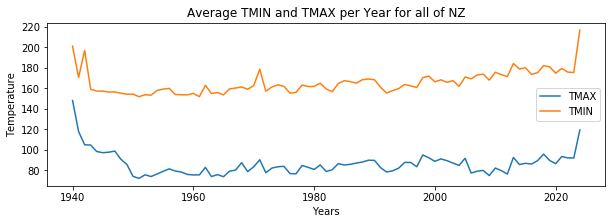

In [91]:
filtered_df = NZ_STATIONS_DF.filter((NZ_STATIONS_DF['ELEMENT'] == 'TMIN') | (NZ_STATIONS_DF['ELEMENT'] == 'TMAX'))
filtered_df = filtered_df.withColumn('DATE', F.to_date(F.col('DATE').cast('string'), 'yyyyMMdd'))
filtered_df = filtered_df.withColumn('YEAR', F.year('DATE'))
avg_df = filtered_df.groupBy('YEAR', 'ELEMENT').agg(F.avg('VALUE').alias('AVG_VALUE'))
pivoted_df = avg_df.groupBy('YEAR').pivot('ELEMENT').agg(F.avg('AVG_VALUE'))
TMIN_data = pivoted_df.select('YEAR', 'TMIN').orderBy('YEAR').collect()
TMIN_years = [row['YEAR'] for row in TMIN_data]
TMIN_values = [row['TMIN'] for row in TMIN_data]
TMAX_data = pivoted_df.select('YEAR', 'TMAX').orderBy('YEAR').collect()
TMAX_years = [row['YEAR'] for row in TMAX_data]
TMAX_values = [row['TMAX'] for row in TMAX_data]
plot_time_series_years_only(TMIN_values, TMAX_values, TMAX_years, TMIN_years, title='Average TMIN and TMAX per Year for all of NZ')
